### Comparsion w/o Mibile SAM

In [1]:
import glob
import pandas as pd
import os

In [2]:
without_fns_valid = sorted(glob.glob('./logs/without_MobileSAM_logs/*logs*csv'))
without_fns_test = sorted(glob.glob('./logs/without_MobileSAM_logs/*test*csv'))
sam_fns_valid = sorted(glob.glob('./logs/with_MobileSAM_logs/*logs*'))
sam_fns_test = sorted(glob.glob('./logs/with_MobileSAM_logs/*test*csv'))

In [3]:
len(without_fns_valid),len(without_fns_test),len(sam_fns_valid),len(sam_fns_test)

(8, 8, 8, 8)

In [4]:
def IoU_table(origin_fns_valid, origin_fns_test, sam_fns_valid, sam_fns_test):
    results = {}
    for f1, f2, f3, f4 in zip(origin_fns_valid, origin_fns_test, sam_fns_valid, sam_fns_test):
        model_name = os.path.basename(f3).split('_')[0]
        o_v_score = pd.read_csv(f1,index_col=0)['valid_score'].max()
        o_t_score = pd.read_csv(f2)['iou_score'].values[0]
        w_v_score = pd.read_csv(f3, index_col=0)['valid_score'].max()
        w_t_score = pd.read_csv(f4)['iou_score'].values[0]
        results[model_name] = [o_v_score, o_t_score, w_v_score, w_t_score]
    res_df = pd.DataFrame.from_dict(results).T
    res_df = res_df.reset_index()
    res_df.columns = ['Models', 'valid_without', 'test_wwithout', 'valid_sam', 'test_sam']
    return res_df

In [6]:
res_df = IoU_table(without_fns_valid, without_fns_test, sam_fns_valid, sam_fns_test)

In [7]:
res_df

,Models,valid_without,test_wwithout,valid_sam,test_sam
0,deeplab3+,0.958445,0.960201,0.962169,0.963746
1,deeplab3,0.956814,0.957922,0.960779,0.962453
2,fpn,0.958357,0.959535,0.962471,0.964387
3,linknet,0.957653,0.959274,0.961698,0.963073
4,maenet,0.958295,0.959436,0.963342,0.965302
5,pan,0.956763,0.958190,0.962139,0.963779
6,unet,0.958245,0.960675,0.964245,0.965367
7,unetpp,0.959556,0.960998,0.963301,0.964757


In [8]:
res_df.to_csv('./logs/SegModelIoU.csv')

### Create mask as Array

##### masks for models with/without sam

In [9]:
import os
import glob
from collections import defaultdict
import pandas as pd

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader
import segmentation_models_pytorch as seg

In [11]:
from dataloader.DownyData import DownyData
from dataloader.data_aug import get_val_aug, get_processing

In [12]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"

In [20]:
models_weights = sorted(glob.glob('./logs/with_MobileSAM_logs/*pth'))
image_dir = '../datasets/Seg_datasets/test/images/'
masks_dir = '../datasets/Seg_datasets/test/masks/'
out_fld = './logs/with_masks/'

In [21]:
def create_mask_array(image_dir, masks_dir, model_weights, out_fld):
    CLASSES = ['disc', 'downy']    
    ENCODER = 'resnet34'
    ENCODER_WEIGHTS = 'imagenet'
    preprocess_fn = seg.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)
    test_dadasets = DownyData(images_dir=image_dir, masks_dir=masks_dir, augmentation=get_val_aug(),
                                  preprocessing=get_processing(preprocess_fn), classes=CLASSES)
    test_loader = DataLoader(test_dadasets, batch_size=1, shuffle=False, num_workers=8)
    image_names = test_dadasets.ids
    
    for weight in models_weights:
        model_name = os.path.basename(weight).split('_')[0]
        print(model_name)
        best_model = torch.load(weight, map_location=device)
        for batch, name in zip(test_loader, image_names):
            img, mask = batch
            # the predict way swith mode to "eval" or "forward" with torch.no_grad()
            pr_mask = best_model.predict(img.to(device))
            pr_mask = (pr_mask.squeeze().cpu().numpy().round())
            outdir = out_fld + model_name + '/' 
            if not os.path.exists(outdir):
                os.makedirs(outdir)
            np.save(outdir + name[:-4], pr_mask)
        torch.cuda.empty_cache()

In [22]:
create_mask_array(image_dir, masks_dir, models_weights, out_fld)

deeplab3+
deeplab3
fpn
linknet
maenet
pan
unet
unetpp


In [23]:
del models_weights, image_dir, masks_dir, out_fld

####  1:1 line for predicted disease serverity and ground truth

In [25]:
from sklearn.metrics import r2_score

In [72]:
true_masks_fld = sorted(glob.glob('../datasets/Seg_datasets/test/masks/*'))
predict_masks_fld = './logs/without_masks/'
models_list = os.listdir(predict_masks_fld)

In [73]:
def get_ground_predict_severity(true_masks_fld, models_list, predict_masks_fld):
    results = defaultdict(list)
    for m_name in models_list:
        predict_masks = sorted(glob.glob( predict_masks_fld+ m_name +'/*'))
        for tfn, pfn in zip(true_masks_fld, predict_masks):
            t_arr = np.load(tfn)
            p_arr = np.load(pfn)
            t1 = (t_arr == 2).sum()
            t2 = (t_arr == 1).sum()
            truth = t1 / (t1 + t2)
            p1 = (p_arr[0,:,:]).sum()
            p2 = (p_arr[1,:,:]).sum()
            predict = p2 / (p1 + p2)
            results['Models'].append(m_name)
            results['Ground truth'].append(truth)
            results['Predict'].append(predict)
    df = pd.DataFrame.from_dict(results)
    return df

In [74]:
df = get_ground_predict_severity(true_masks_fld, models_list, predict_masks_fld)

In [75]:
df.to_csv('./logs/ground_predict_without.csv')

#### make plots

In [83]:
df_w = pd.read_csv('./logs/ground_predict_with.csv',index_col=0)

In [84]:
df_wo = pd.read_csv('./logs/ground_predict_without.csv',index_col=0)

In [88]:
df_w['Predict']

0       0.000000
1       0.000000
2       0.000000
3       0.000000
4       0.000000
          ...   
4251    0.000000
4252    0.094132
4253    0.043769
4254    0.074320
4255    0.000000
Name: Predict, Length: 4256, dtype: float64

In [90]:
df_wo['Predict']

0       0.000000
1       0.000000
2       0.000000
3       0.000000
4       0.000000
          ...   
4251    0.000000
4252    0.086127
4253    0.047451
4254    0.079428
4255    0.000000
Name: Predict, Length: 4256, dtype: float64

In [76]:
import matplotlib.pyplot as plt

In [77]:
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['xtick.labelsize'] = 7
plt.rcParams['ytick.labelsize'] = 7

In [ ]:
df = pd.read_csv('./logs/ground_predict_without.csv', index_col=0)

replace_name = {'maenet':'MANet', "deeplab3+":"DeepLab V3+", "unet":"UNet","unetpp":"UNet++", 
                "deeplab3":"DeepLab V3", "fpn":"FPN", "pan":"PAN","linknet":"LinkNet"}

df['Models'] = df['Models'].map(replace_name)

df = df.sort_values(by='Models')

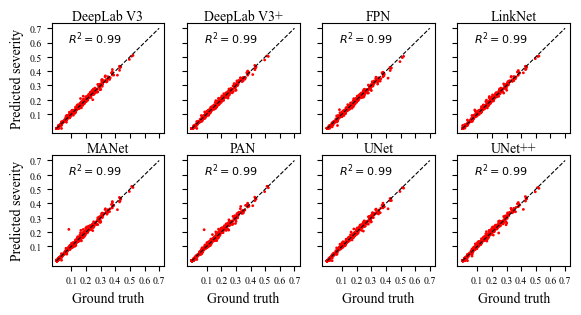

In [82]:
fig, axs = plt.subplots(nrows=2, ncols=4, figsize=(17/2.54, 8/2.54),
                        sharex=True, sharey=True)
axs = axs.flatten()
i = 0
for mm in df['Models'].unique():
    temp = df[df['Models'] == mm]
    axs[i].scatter(temp['Ground truth'], temp["Predict"], s=1, color='r', facecolor='none')
    axs[i].plot([0, 0.7],[0, 0.7], color='k', ls='--', lw=0.8)

    r2 = r2_score(temp['Ground truth'], temp['Predict'])
    r2 = round(r2, ndigits=2)
    
    axs[i].set_xticks(ticks=[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7],
                      labels=[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7])
    axs[i].set_yticks(ticks=[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7],
                      labels=[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7])
    axs[i].set_title(mm, fontsize=10, pad=0)

    axs[i].text(0.08, 0.6, s="$R^2={0}$".format(r2), fontsize=8)
    
    if i > 3:
        axs[i].set_xlabel('Ground truth', fontsize=10)
    axs[0].set_ylabel('Predicted severity', fontsize=10)
    axs[4].set_ylabel('Predicted severity', fontsize=10)
    
    i += 1
# plt.savefig('../figs/line11_ground_perdict_wo.jpg', dpi=500, bbox_inches='tight')

#### plot Confusion Matrix

In [70]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

In [71]:
df = pd.read_csv('./logs/ground_predict_wsam.csv', index_col=0)
# df = pd.read_csv('./logs/ground_predict_wosam.csv', index_col=0)
replace_name = {'maenet':'MANet', "deeplab3+":"DeepLab V3+", "unet":"UNet","unetpp":"UNet++", 
                "deeplab3":"DeepLab V3", "fpn":"FPN", "pan":"PAN","linknet":"LinkNet"}
df['Models'] = df['Models'].map(replace_name)
df = df.sort_values(by='Models')

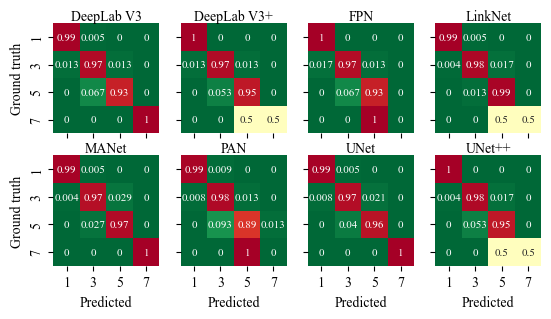

In [72]:
bins = [-0.5, 0.05, 0.25, 0.50, 0.75]
labels = [1, 3, 5, 7]
fig, axs = plt.subplots(2, 4, figsize=(16/2.54, 8/2.54),
                        sharex=True, sharey=True)
axs = axs.flatten()
i = 0
for mm in df.Models.unique():
    temp = df[df['Models']==mm]
    x = temp['Ground truth']
    y = temp['Predict']
    xb = pd.cut(x, bins=bins, labels=labels)
    yb = pd.cut(y, bins=bins, labels=labels)
    matrix = confusion_matrix(xb, yb, normalize='true')
    matrix = matrix.round(decimals=3)
    p = sns.heatmap(matrix, annot=True, ax=axs[i], cbar=False, cmap='RdYlGn_r',
                   annot_kws={'fontsize':8})
    p.set_xticks(ticks=[0.5, 1.5, 2.5, 3.5], labels=[1, 3, 5, 7], fontsize=10)

    p.set_yticks(ticks=[0.5, 1.5, 2.5, 3.5], labels=[1, 3, 5, 7], fontsize=10)
    p.set_title(mm, fontsize=10, pad=0)
    if i > 3:
        axs[i].set_xlabel('Predicted', fontsize=10)
    axs[0].set_ylabel('Ground truth', fontsize=10)
    axs[4].set_ylabel('Ground truth', fontsize=10)
    i += 1
# plt.savefig('../figs/headmap_level_w.jpg', dpi=500, bbox_inches='tight')

#### all images diseases serverity / level  bar plot

In [56]:
import glob

In [57]:
mask_npys = glob.glob('../datasets/Seg_datasets/*/masks/*')

In [58]:
results = []
for msk in mask_npys:
    arr = np.load(msk)
    d1 = (arr==2).sum()
    d2 = (arr==1).sum()
    severity = d1 / (d1+ d2)
    results.append(severity)

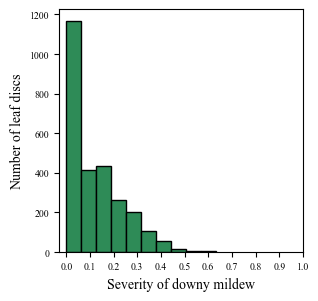

In [59]:
fig,ax = plt.subplots(1,1,figsize=(8/2.54, 8/2.54))
ax.hist(results, color='seagreen', edgecolor='k')
plt.xticks(ticks=np.arange(0,1.1,0.1), labels=[str(round(j,ndigits=1)) for j in np.arange(0,1.1,0.1)]);
plt.ylabel('Number of leaf discs')
plt.xlabel('Severity of downy mildew')
plt.savefig('../figs/diseases_statistics.jpg', dpi=500,bbox_inches='tight')

### Creat Painted Masks for leaf disc  

In [60]:
import glob
import numpy as np
import torch
from torch.utils.data import DataLoader
import torchvision.transforms.functional as F
from torchvision.io import read_image
from torchvision.transforms import v2
from torchvision.utils import draw_segmentation_masks

In [61]:
def show(imgs, outname):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fig, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = F.to_pil_image(img)
        img = img.resize((224, 224))
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])
    plt.savefig(outname, bbox_inches='tight')

In [ ]:
origin_images = sorted(glob.glob('../datasets/Origin_Seg_datasets/test/images/*'))
origin_masks = sorted(glob.glob('../datasets/Origin_Seg_datasets/test/masks/*'))
for mname in os.listdir('./logs/Mask_W_O/'):
    pattern = './logs/Mask_W_O/' + mname +'/*npy'
    pr_masks = sorted(glob.glob(pattern))
    for oi, pm in zip(origin_images, pr_masks):
        bname1 = os.path.basename(oi)[:-4]
        bname2 = os.path.basename(pm)[:-4]
        assert bname1 == bname2
        img = read_image(oi)
        img = v2.Resize(size=(224, 224), antialias=True)(img)
        mask = np.load(pm)
        mask = torch.from_numpy(mask).bool()
        with_masks = [draw_segmentation_masks(img, masks=mask, alpha=0.3, colors=['green', 'red'])]
        outdir = './logs/colored_wo_masks/' + mname + '/'
        if not os.path.exists(outdir):
            os.makedirs(outdir)
        outname = outdir + bname1 + '.jpg'
        show(with_masks, outname)

In [ ]:
origin_images = sorted(glob.glob('../datasets/Seg_datasets/test/images/*'))
origin_masks = sorted(glob.glob('../datasets/Seg_datasets/test/masks/*'))
for oi, om in zip(origin_images, origin_masks):
    bname1 = os.path.basename(oi)[:-4]
    bname2 = os.path.basename(om)[:-4]
    assert bname1 == bname2
    img = read_image(oi)
    ground = np.load(om)
    ground_list = [(ground == v) for v in [1, 2]]
    ground = np.stack(ground_list, axis=0).astype('float')
    ground = torch.from_numpy(ground).bool()
    with_masks = [draw_segmentation_masks(img, masks=ground, alpha=0.3, colors=['green', 'red'])]
    outname = './logs/colored_origin_masks/' + bname1 + '.jpg'
    show(with_masks, outname)

### mv agrget images

In [10]:
import os
import glob
import shutil
from pprint import pprint

In [2]:
name_list = ["16-1-1-1(20)_17.jpg", "16-1-1-1(40)1_8.jpg",
             "IMG_2203_17.jpg","IMG_2217_2.jpg", "IMG_2317_5.jpg",
             "IMG_8566_13.jpg", "IMG_8577_16.jpg", "IMG_8656_8.jpg",
             "IMG_9002_6.jpg", "IMG_9010_11.jpg"]

In [12]:
test_folders = ['../datasets/Origin_dataset/test/images/', '../datasets/Seg_dataset/test/images/']
orig_dst = {}
for name in name_list:
    orig0 = test_folders[0] + name
    orig1 = test_folders[1] + name
    orig0_dst = orig0.replace('.jpg', '_origin.jpg').replace(test_folders[0], '')
    orig1_dst = orig1.replace('.jpg', '_seg.jpg').replace(test_folders[1], '')
    orig_dst[orig0]= orig0_dst
    orig_dst[orig1]= orig1_dst
mask_folder = ['./logs/with_ms_masks/', './logs/without_ms_masks/']
labels = ['with', 'without']
for label, folder in zip(labels, mask_folder):
    for name in name_list:    
        img_list = glob.glob(folder+'*/'+name)
        for fn in img_list:
            dst = fn.replace(folder, '').replace('/','_'+label+'_')
            orig_dst[fn] = dst

In [ ]:
pprint(orig_dst)

In [77]:
import pandas as pd

In [78]:
df1 = pd.read_csv('./logs/with.csv',index_col=0)

In [79]:
df1

,Path,Models,t_leaf,t_downy,Ground truth,p_leaf,p_downy,Predict
0,16-1-1-1(1)_10.npy,maenet,44064,0,0.000000,39321.0,0.0,0.000000
1,16-1-1-1(1)_13.npy,maenet,43373,0,0.000000,38714.0,0.0,0.000000
2,16-1-1-1(1)_6.npy,maenet,42192,0,0.000000,39393.0,0.0,0.000000
3,16-1-1-1(100)_12.npy,maenet,17545,0,0.000000,38886.0,0.0,0.000000
4,16-1-1-1(100)_7.npy,maenet,17747,0,0.000000,38919.0,0.0,0.000000
...,...,...,...,...,...,...,...,...
4251,IMG_9447_8.npy,linknet,47655,0,0.000000,39666.0,0.0,0.000000
4252,IMG_9448_17.npy,linknet,37932,3776,0.090534,35851.0,3658.0,0.092587
4253,IMG_9448_18.npy,linknet,39311,2185,0.052656,37538.0,2021.0,0.051088
4254,IMG_9448_7.npy,linknet,36472,3318,0.083388,36732.0,2943.0,0.074178


In [80]:
df2 = pd.read_csv('./logs/without.csv', index_col=0)

In [81]:
df2

,Path,Models,t_leaf,t_downy,Ground truth,p_leaf,p_downy,Predict
0,16-1-1-1(1)_10.npy,maenet,44064,0,0.000000,39126.0,0.0,0.000000
1,16-1-1-1(1)_13.npy,maenet,43373,0,0.000000,38520.0,0.0,0.000000
2,16-1-1-1(1)_6.npy,maenet,42192,0,0.000000,39138.0,0.0,0.000000
3,16-1-1-1(100)_12.npy,maenet,17545,0,0.000000,38871.0,0.0,0.000000
4,16-1-1-1(100)_7.npy,maenet,17747,0,0.000000,38972.0,0.0,0.000000
...,...,...,...,...,...,...,...,...
4251,IMG_9447_8.npy,linknet,47655,0,0.000000,39446.0,0.0,0.000000
4252,IMG_9448_17.npy,linknet,37932,3776,0.090534,35554.0,3450.0,0.088452
4253,IMG_9448_18.npy,linknet,39311,2185,0.052656,37496.0,1897.0,0.048156
4254,IMG_9448_7.npy,linknet,36472,3318,0.083388,36329.0,3098.0,0.078576


In [92]:
a0 = df1[['t_downy','t_leaf']].groupby(df1['Models']).mean()

In [86]:
a1 = df1[['p_downy','p_leaf']].groupby(df1['Models']).mean()

In [87]:
a2 = df2[['p_downy','p_leaf']].groupby(df2['Models']).mean()

In [101]:
a0

,t_downy,t_leaf
Models,,
deeplab3,6663.336466,48632.503759
deeplab3+,6663.336466,48632.503759
fpn,6663.336466,48632.503759
linknet,6663.336466,48632.503759
maenet,6663.336466,48632.503759
pan,6663.336466,48632.503759
unet,6663.336466,48632.503759
unetpp,6663.336466,48632.503759


In [13]:
difference = df2['Predict'] - df1['Predict']

In [14]:
df1['Difference'] = difference

In [18]:
df1.sort_values(by='Difference')

,Path,Models,Ground truth,Predict,Difference
1089,16-1-1-1(21)_5.npy,unet,0.165256,0.240565,-0.057100
2363,IMG_8654_8.npy,deeplab3,0.167364,0.214095,-0.035164
1891,IMG_9105_16.npy,unetpp,0.141387,0.151348,-0.034471
1627,16-1-1-1(27)_15.npy,unetpp,0.209736,0.213955,-0.033725
1649,16-1-1-1(39)1_7.npy,unetpp,0.320920,0.344733,-0.032989
...,...,...,...,...,...
50,16-1-1-1(37)1_12.npy,maenet,0.097736,0.088425,0.031554
92,IMG_0055_10.npy,maenet,0.189946,0.171661,0.045776
295,IMG_9105_16.npy,maenet,0.141387,0.123000,0.054659
3487,IMG_9105_16.npy,pan,0.141387,0.120617,0.063630


In [26]:
target_df = df1[df1['Difference'].abs() >= 0.03]

In [30]:
target_images = target_df['Path'].str.replace('.npy', '.jpg')

In [35]:
target_images

50      16-1-1-1(37)1_12.jpg
92           IMG_0055_10.jpg
295          IMG_9105_16.jpg
653           IMG_2102_8.jpg
1077      16-1-1-1(14)_7.jpg
1089      16-1-1-1(21)_5.jpg
1575          IMG_9440_2.jpg
1622    16-1-1-1(210)_10.jpg
1627     16-1-1-1(27)_15.jpg
1649     16-1-1-1(39)1_7.jpg
1785          IMG_7042_6.jpg
1891         IMG_9105_16.jpg
2363          IMG_8654_8.jpg
3456          IMG_9008_9.jpg
3487         IMG_9105_16.jpg
3612          IMG_9353_3.jpg
4235          IMG_9440_2.jpg
Name: Path, dtype: object

In [32]:
target_images.to_csv('./logs/biggest_diff_imgpath.csv', index=None)

In [62]:
import glob
import os
import matplotlib.pyplot as plt

In [48]:
origin_fns = sorted(glob.glob('./logs/compare_masks/*g*.jpg'), key=lambda f:f.split('_')[-1])

In [60]:
models_names = os.listdir('./logs/with_ms_masks/')

In [ ]:
for name in models_names:
    pattern = './logs/compare_masks/'+ name +'_*.jpg'
    fns = reversed(sorted(glob.glob(pattern)))
    fig, axs = plt.subplots(ncols=14, nrows=2,figsize=(20,10))
    axs = axs.flatten()
    for i, fn in enumerate(fns):
        img = plt.imread(fn)
        axs[i].imshow(img)
        axs[i].axis('off')
    plt.savefig('./logs/masks_concat/'+ name +'.jpg', bbox_inches='tight')

###  segmentation error for background

In [109]:
import numpy as np

In [111]:
mask=np.load('../datasets/Origin_dataset/test/masks/16-1-1-1(37)1_12.npy')

In [115]:
msk_new = np.resize(mask, new_shape=(224,224))

In [118]:
pred_mask = np.load('./logs/without_ms_masks/deeplab3/16-1-1-1(37)1_12.npy')

In [121]:
pred_mask

array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]], dtype=float32)

In [129]:
pred_mask_new = pred_mask.sum(axis=0)

In [137]:
pred_mask_new

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [145]:
(pred_mask_new[np.where(msk_new==0)] == 1)

6509

### 1:1 line

In [29]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import r2_score, confusion_matrix
import seaborn as sns

In [16]:
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['xtick.labelsize'] = 7
plt.rcParams['ytick.labelsize'] = 7

In [2]:
df = pd.read_csv('./logs/with.csv', index_col=0)

In [3]:
df.head()

,Path,Models,t_leaf,t_downy,Ground truth,p_leaf,p_downy,Predict
0,16-1-1-1(1)_10.npy,maenet,44064,0,0.0,39321.0,0.0,0.0
1,16-1-1-1(1)_13.npy,maenet,43373,0,0.0,38714.0,0.0,0.0
2,16-1-1-1(1)_6.npy,maenet,42192,0,0.0,39393.0,0.0,0.0
3,16-1-1-1(100)_12.npy,maenet,17545,0,0.0,38886.0,0.0,0.0
4,16-1-1-1(100)_7.npy,maenet,17747,0,0.0,38919.0,0.0,0.0


In [4]:
replace_name = {'maenet':'MANet', "deeplab3+":"DeepLab V3+", "unet":"UNet","unetpp":"UNet++", 
                "deeplab3":"DeepLab V3", "fpn":"FPN", "pan":"PAN","linknet":"LinkNet"}

df['Models'] = df['Models'].map(replace_name)

df = df.sort_values(by='Models')

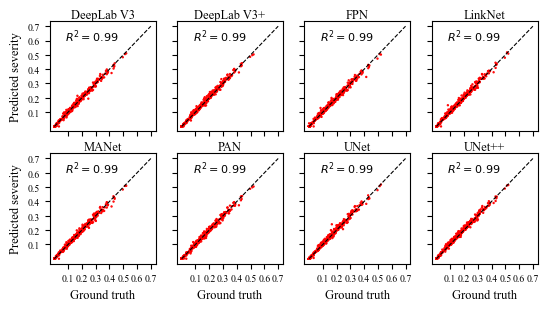

In [26]:
fig, axs = plt.subplots(nrows=2, ncols=4, figsize=(16/2.54, 8/2.54),
                        sharex=True, sharey=True)
axs = axs.flatten()
i = 0
for mm in df['Models'].unique():
    temp = df[df['Models'] == mm]
    axs[i].scatter(temp['Ground truth'], temp["Predict"], s=0.5, color='r', facecolor='none')
    axs[i].plot([0, 0.7],[0, 0.7], color='k', ls='--', lw=0.8)

    r2 = r2_score(temp['Ground truth'], temp['Predict'])
    r2 = round(r2, ndigits=2)
    
    axs[i].set_xticks(ticks=[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7],
                      labels=[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7])
    axs[i].set_yticks(ticks=[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7],
                      labels=[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7])
    axs[i].set_title(mm, fontsize=9, pad=0)

    axs[i].text(0.08, 0.6, s="$R^2={0}$".format(r2), fontsize=8)
    
    if i > 3:
        axs[i].set_xlabel('Ground truth', fontsize=9)
    axs[0].set_ylabel('Predicted severity', fontsize=9)
    axs[4].set_ylabel('Predicted severity', fontsize=9)
    
    i += 1
plt.savefig('../figs/severity11.jpg', bbox_inches='tight', dpi=300)

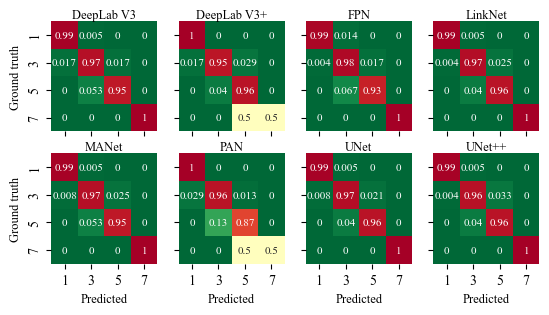

In [32]:
bins = [-0.5, 0.05, 0.25, 0.50, 0.75]
labels = [1, 3, 5, 7]
fig, axs = plt.subplots(2, 4, figsize=(16/2.54, 8/2.54),
                        sharex=True, sharey=True)
axs = axs.flatten()
i = 0
for mm in df.Models.unique():
    temp = df[df['Models']==mm]
    x = temp['Ground truth']
    y = temp['Predict']
    xb = pd.cut(x, bins=bins, labels=labels)
    yb = pd.cut(y, bins=bins, labels=labels)
    matrix = confusion_matrix(xb, yb, normalize='true')
    matrix = matrix.round(decimals=3)
    p = sns.heatmap(matrix, annot=True, ax=axs[i], cbar=False, cmap='RdYlGn_r',
                   annot_kws={'fontsize':8})
    p.set_xticks(ticks=[0.5, 1.5, 2.5, 3.5], labels=[1, 3, 5, 7], fontsize=10)

    p.set_yticks(ticks=[0.5, 1.5, 2.5, 3.5], labels=[1, 3, 5, 7], fontsize=10)
    p.set_title(mm, fontsize=9, pad=0)
    if i > 3:
        axs[i].set_xlabel('Predicted', fontsize=9)
    axs[0].set_ylabel('Ground truth', fontsize=9)
    axs[4].set_ylabel('Ground truth', fontsize=9)
    i += 1
plt.savefig('../figs/headmap_level.jpg', dpi=500, bbox_inches='tight')

### examples for masks

In [63]:
import matplotlib.pyplot as plt
import os
from PIL import Image

In [35]:
image_list = ["16-1-1-1(20)_17.jpg", "16-1-1-1(40)1_8.jpg", "IMG_2203_17.jpg","IMG_2217_2.jpg",  "IMG_2317_5.jpg"]

In [39]:
model_dir = './logs/with_ms_masks/'
models_names = os.listdir(model_dir)

In [58]:
all_imgs_list = []
for i, name in enumerate(image_list):
    origin_fn = '../datasets/Seg_dataset/test/images/' + name
    groud =  './logs/ground_mask/' + name
    models_fns = []
    for model in models_names:
        img_fn = model_dir + model + '/' + name
        models_fns.append(img_fn)
    imgs_list = [origin_fn, groud] + models_fns
    all_imgs_list.append(imgs_list)

In [59]:
all_imgs_list

[['../datasets/Seg_dataset/test/images/16-1-1-1(20)_17.jpg',
  './logs/ground_mask/16-1-1-1(20)_17.jpg',
  './logs/with_ms_masks/maenet/16-1-1-1(20)_17.jpg',
  './logs/with_ms_masks/deeplab3+/16-1-1-1(20)_17.jpg',
  './logs/with_ms_masks/unet/16-1-1-1(20)_17.jpg',
  './logs/with_ms_masks/unetpp/16-1-1-1(20)_17.jpg',
  './logs/with_ms_masks/deeplab3/16-1-1-1(20)_17.jpg',
  './logs/with_ms_masks/fpn/16-1-1-1(20)_17.jpg',
  './logs/with_ms_masks/pan/16-1-1-1(20)_17.jpg',
  './logs/with_ms_masks/linknet/16-1-1-1(20)_17.jpg'],
 ['../datasets/Seg_dataset/test/images/16-1-1-1(40)1_8.jpg',
  './logs/ground_mask/16-1-1-1(40)1_8.jpg',
  './logs/with_ms_masks/maenet/16-1-1-1(40)1_8.jpg',
  './logs/with_ms_masks/deeplab3+/16-1-1-1(40)1_8.jpg',
  './logs/with_ms_masks/unet/16-1-1-1(40)1_8.jpg',
  './logs/with_ms_masks/unetpp/16-1-1-1(40)1_8.jpg',
  './logs/with_ms_masks/deeplab3/16-1-1-1(40)1_8.jpg',
  './logs/with_ms_masks/fpn/16-1-1-1(40)1_8.jpg',
  './logs/with_ms_masks/pan/16-1-1-1(40)1_8.jpg',

In [75]:
m_names = ['Origin', 'Ground','MAENet','DeepLab V3+', 'UNet', 'UNet++','DeepLab V3', 'FPN','PAN', 'LinkNet']

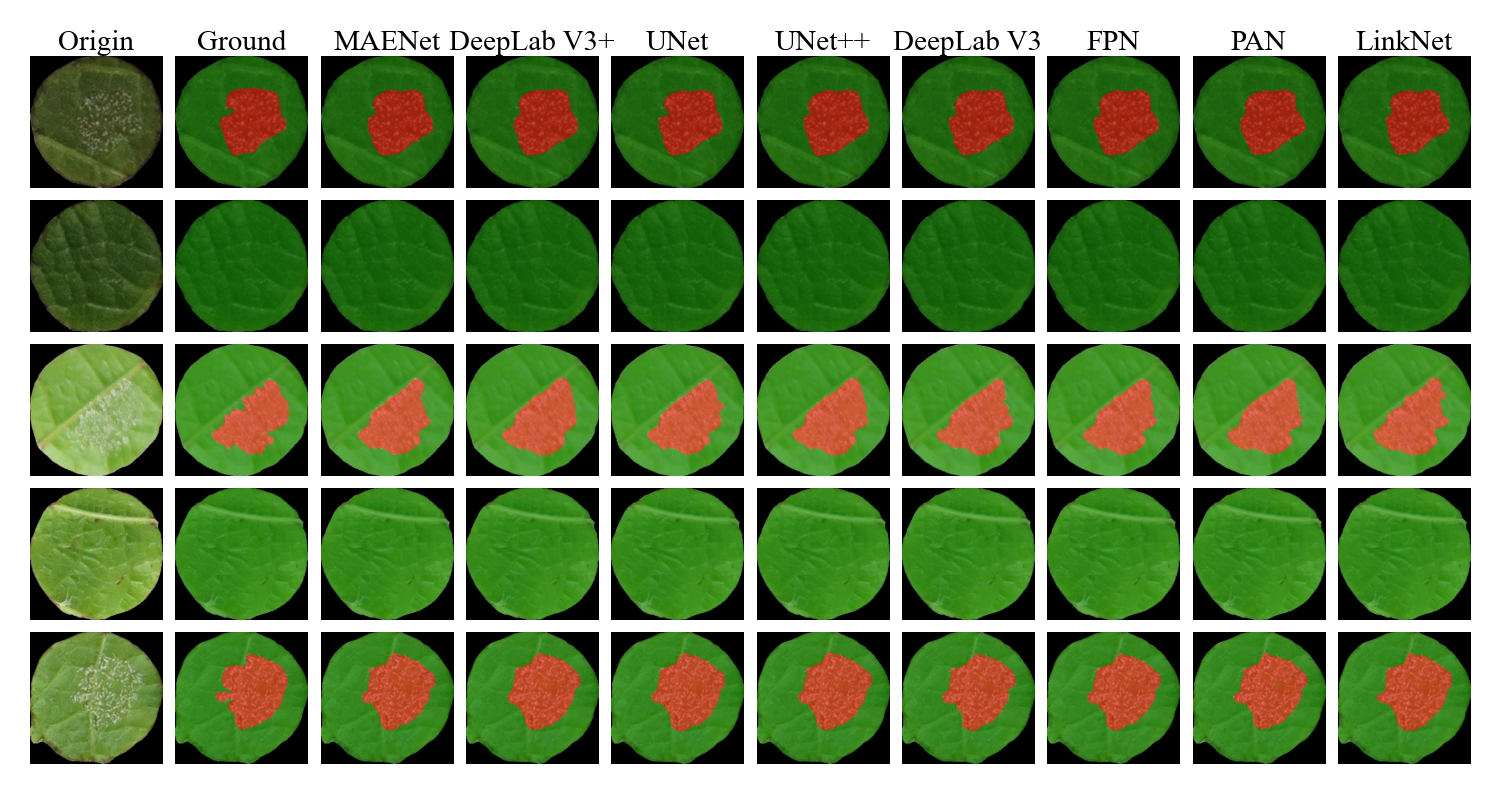

In [103]:
fig, axs = plt.subplots(ncols=10, nrows=5, figsize=(6, 4),dpi=300)
for i, fn_list in enumerate(all_imgs_list):
    for j in range(10):
        img = Image.open(fn_list[j])
        if j == 0 :
            img = img.resize((224,224))
        axs[i,j].imshow(img)
        axs[i,j].axis('off')
        if i == 0:
            axs[i,j].set_title(m_names[j], fontsize=7, pad=0.1)
plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.3, wspace=0.1, hspace=0)
plt.savefig('../figs/Fig5.jpg', dpi=500, bbox_inches='tight')

In [104]:
import time

In [105]:
start = time.time()

In [106]:
end = time.time()

In [107]:
duration = end - start

In [111]:
532 / duration

88.25995119333314